#### Installing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.3, max_features=10000)
from sklearn import feature_extraction, feature_selection, model_selection

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from imblearn.over_sampling import RandomOverSampler
sampler=RandomOverSampler()

from sklearn.model_selection import train_test_split
def create_train_test_split(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42069)
    return X_train, X_test, Y_train, Y_test

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def sparseTFIDF(X_train, X_test, Y_train):
    vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.3, max_features=10000)
    
    #Extract Vocabulary
    corpus = X_train["preprocessed_posts"].values.astype(str)
    vectorizer.fit(corpus)
    X_training = vectorizer.transform(corpus)
    dic_vocabulary = vectorizer.vocabulary_

    #FEATURE SELECTION
    #Reduce Dimensionality for sparse data with Chi-Quadrat
    X_names = vectorizer.get_feature_names_out()
    p_value_limit = 0.95
    features = pd.DataFrame()

    for cat in np.unique(Y_train):
        chi2, p = feature_selection.chi2(X_training, Y_train == cat)
        features = features.append(pd.DataFrame(
            {"feature": X_names, "score": 1 - p, "y": cat}))
        features = features.sort_values(["y", "score"], ascending=[True, False])
        features = features[features["score"] > p_value_limit]
    X_names = features["feature"].unique().tolist()

    #Re-Fit vectorizer on corpus with new set of words and create new sparse matrix
    vectorizer = TfidfVectorizer(vocabulary=X_names)
    vectorizer.fit(corpus)

    df_tfidfvect = vectorizer.transform(corpus)
    tfidf_tokens = vectorizer.get_feature_names()
    df_tfidfvect = pd.DataFrame(data = df_tfidfvect.toarray(),columns = tfidf_tokens)


    corpus = X_test["preprocessed_posts"].values.astype(str)
    df_tfidfvect_test = vectorizer.transform(corpus)
    dic_vocabulary = vectorizer.vocabulary_

    tfidf_tokens_test = vectorizer.get_feature_names()
    df_tfidfvect_test = pd.DataFrame(data = df_tfidfvect_test.toarray(),columns = tfidf_tokens_test)

    return df_tfidfvect, df_tfidfvect_test

plot-confusion-matrix function from class

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

function assigning numeric representation of MBTItype according to predictions based on the four binary models.

In [4]:
def numMBTItype(row):
    if row['EI'] == 1:
        if row['NS'] == 1:
            if row['FT'] == 1:
                if row['PJ'] == 1:
                    return 7 # ENFP
                else: # ENFJ
                    return 5
            else: 
                if row['PJ'] == 1:
                    return 1 # ENTP
                else: # ENTJ
                    return 4
        else: 
            if row['FT'] == 1:
                if row['PJ'] == 1:
                    return 13 # ESFP
                else: # ESFJ
                    return 15
            else: 
                if row['PJ'] == 1:
                    return 12 # ESTP
                else: # ESTJ
                    return 14
    else: 
        if row['NS'] == 1:
            if row['FT'] == 1:
                if row['PJ'] == 1:
                    return 6 # INFP
                else: # INFJ
                    return 0
            else: 
                if row['PJ'] == 1:
                    return 2 # INTP
                else: # INTJ
                    return 3
        else: 
            if row['FT'] == 1:
                if row['PJ'] == 1:
                    return 8 # ISFP
                else: # ISFJ
                    return 10
            else: 
                if row['PJ'] == 1:
                    return 9 # ISTP
                else: # ISTJ
                    return 11

In [5]:
def MBTItype(row):
    if row['EI'] == 1:
        if row['NS'] == 1:
            if row['FT'] == 1:
                if row['PJ'] == 1:
                    return 'ENFP'
                else:
                    return 'ENFJ'
            else: 
                if row['PJ'] == 1:
                    return 'ENTP'
                else:
                    return 'ENTJ'
        else: 
            if row['FT'] == 1:
                if row['PJ'] == 1:
                    return 'ESFP'
                else:
                    return 'ESFJ'
            else: 
                if row['PJ'] == 1:
                    return 'ESTP'
                else:
                    return 'ESTJ'
    else: 
        if row['NS'] == 1:
            if row['FT'] == 1:
                if row['PJ'] == 1:
                    return 'INFP'
                else:
                    return 'INFJ'
            else: 
                if row['PJ'] == 1:
                    return 'INTP'
                else:
                    return 'INTJ'
        else: 
            if row['FT'] == 1:
                if row['PJ'] == 1:
                    return 'ISFP'
                else:
                    return 'ISFJ'
            else: 
                if row['PJ'] == 1:
                    return 'ISTP'
                else:
                    return 'ISTJ'

#### Load preprocessed Data Frame

In [6]:
df = pd.read_csv('./mbti_preprocessed_complete.csv')
display(df.head())

,Unnamed: 0,type,posts,encodedType,preprocessed_posts,extro_intro,intu_obs,feel_think,prosp_judg
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,8,"['youtube', 'tumblr', 'enfp', 'intj', 'moment'...",0,1,1,0
1,1,ENTP,'I'm finding the lack of me in these posts ver...,3,"['im', 'finding', 'the', 'lack', 'of', 'post',...",1,1,0,1
2,2,INTP,'Good one _____ https://www.youtube.com/wat...,11,"['good', 'one', 'youtube', 'of', 'course', 'i'...",0,1,0,1
3,3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",10,"['dear', 'intp', 'i', 'enjoyed', 'conversation...",0,1,0,0
4,4,ENTJ,'You're fired.|||That's another silly misconce...,2,"['youre', 'fired', 'thats', 'another', 'silly'...",1,1,0,0


Select columns which will serve as target and training data. Here target is the 16 MBTI categories. While the training data consists of the preprocessed posts which will be verctorized using TF-IDF.

In [7]:
feature = ['avg_word_count', 'avg_exclam_count', 'avg_fullstop_count', 'avg_count_of_hello', 'avg_count_of_hi', 'avg_count_of_extroverted_bigrams',
           'avg_count_of_extroverted_stylistic_impressions', 'avg_count_of_interoverted_quantifiers', 'avg_count_of_introverted_first_person_singular_pronoun', 'avg_count_of_introverted_negations']

X = pd.DataFrame(df.iloc[:,4])
X_feature = pd.DataFrame(df.iloc[:,9:20])
X = pd.concat([X, X_feature], axis=1)

Y_EI = df.iloc[:,5].values # E Extroverted (1) - I Introverted (0)
Y_NS = df.iloc[:,6].values # N Intuitive (1) - S Observant (0)
Y_FT = df.iloc[:,7].values # F Feeling (1) - T Thinking (0)
Y_PJ = df.iloc[:,8].values # P Prospective (1) - J Judging (0)
print('Extroverted (1) - Introverted (0)')
display(pd.DataFrame(Y_EI).value_counts())
print('Intuitive (1) -  Observant (0)')
display(pd.DataFrame(Y_NS).value_counts())
print('Feeling (1) - Thinking (0)')
display(pd.DataFrame(Y_FT).value_counts())
print('Prospective (1) - Judging (0)')
display(pd.DataFrame(Y_PJ).value_counts())

Extroverted (1) - Introverted (0)


0    6676
1    1999
dtype: int64

Intuitive (1) -  Observant (0)


1    7478
0    1197
dtype: int64

Feeling (1) - Thinking (0)


1    4694
0    3981
dtype: int64

Prospective (1) - Judging (0)


1    5241
0    3434
dtype: int64

Split into train and test datasets.

In [8]:
X_train, X_test, Y_train_EI, Y_test_EI = create_train_test_split(X, Y_EI)
X_train, X_test, Y_train_NS, Y_test_NS = create_train_test_split(X, Y_NS)
X_train, X_test, Y_train_FT, Y_test_FT = create_train_test_split(X, Y_FT)
X_train, X_test, Y_train_PJ, Y_test_PJ = create_train_test_split(X, Y_PJ)

Balance the training dataset.

In [9]:
X_train_balanced_EI, Y_train_balanced_EI = sampler.fit_resample(X_train, Y_train_EI)
X_train_balanced_NS, Y_train_balanced_NS = sampler.fit_resample(X_train, Y_train_NS)
X_train_balanced_FT, Y_train_balanced_FT = sampler.fit_resample(X_train, Y_train_FT)
X_train_balanced_PJ, Y_train_balanced_PJ = sampler.fit_resample(X_train, Y_train_PJ)

### Models: Centroids and KNN (TF-IDF)

In [10]:
pipeline = Pipeline([ ('estimator', None) ])

#### Centroids

In [11]:
pipeline.set_params(estimator=NearestCentroid())

Pipeline(steps=[('estimator', NearestCentroid())])

##### EI: Extroverted - Introverted
Create sparse TFIDF-Document Termmatrix. \
Then fit the Model and determine the Accuracy.

In [12]:
df_tfidfvect_EI, df_tfidfvect_test_EI = sparseTFIDF(X_train_balanced_EI, X_test, Y_train_balanced_EI)

/var/folders/kh/405kw3wn56x2htwrgh2yhcfw0000gn/T/ipykernel_2215/3762352402.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features = features.append(pd.DataFrame(
/var/folders/kh/405kw3wn56x2htwrgh2yhcfw0000gn/T/ipykernel_2215/3762352402.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features = features.append(pd.DataFrame(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.

Classification Report:
              precision    recall  f1-score   support

           I       0.90      0.75      0.82      2002
           E       0.47      0.74      0.57       601

    accuracy                           0.74      2603
   macro avg       0.69      0.74      0.69      2603
weighted avg       0.80      0.74      0.76      2603



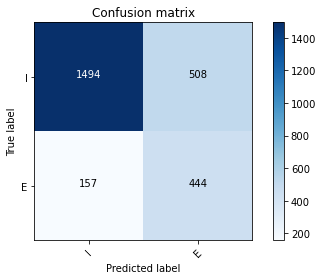

In [13]:
pipeline.fit(df_tfidfvect_EI, Y_train_balanced_EI)
predict_EI = pipeline.predict(df_tfidfvect_test_EI)

print("Classification Report:")
print(classification_report(Y_test_EI, predict_EI, target_names=['I','E']))

cnf = confusion_matrix(Y_test_EI, predict_EI)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = ['I','E'])

##### NS: Intuitive - Observant
Create sparse TFIDF-Document Termmatrix. \
Then fit the Model and determine the Accuracy.

In [14]:
df_tfidfvect_NS, df_tfidfvect_test_NS = sparseTFIDF(X_train_balanced_NS, X_test, Y_train_balanced_NS)

/var/folders/kh/405kw3wn56x2htwrgh2yhcfw0000gn/T/ipykernel_2215/3762352402.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features = features.append(pd.DataFrame(
/var/folders/kh/405kw3wn56x2htwrgh2yhcfw0000gn/T/ipykernel_2215/3762352402.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features = features.append(pd.DataFrame(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.

Classification Report:
              precision    recall  f1-score   support

           S       0.38      0.70      0.49       342
           N       0.95      0.82      0.88      2261

    accuracy                           0.81      2603
   macro avg       0.66      0.76      0.68      2603
weighted avg       0.87      0.81      0.83      2603



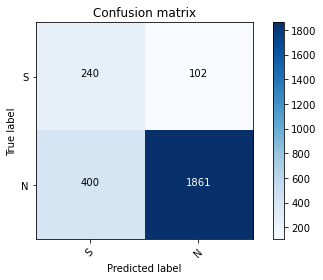

In [15]:
pipeline.fit(df_tfidfvect_NS, Y_train_balanced_NS)
predict_NS = pipeline.predict(df_tfidfvect_test_NS)

print("Classification Report:")
print(classification_report(Y_test_NS, predict_NS, target_names=['S','N']))

cnf = confusion_matrix(Y_test_NS, predict_NS)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = ['S','N'])

##### FT: Feeling - Thinking
Create sparse TFIDF-Document Termmatrix. \
Then fit the Model and determine the Accuracy.

In [16]:
df_tfidfvect_FT, df_tfidfvect_test_FT = sparseTFIDF(X_train_balanced_FT, X_test, Y_train_balanced_FT)

/var/folders/kh/405kw3wn56x2htwrgh2yhcfw0000gn/T/ipykernel_2215/3762352402.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features = features.append(pd.DataFrame(
/var/folders/kh/405kw3wn56x2htwrgh2yhcfw0000gn/T/ipykernel_2215/3762352402.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features = features.append(pd.DataFrame(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.

Classification Report:
              precision    recall  f1-score   support

           T       0.78      0.76      0.77      1199
           F       0.80      0.81      0.81      1404

    accuracy                           0.79      2603
   macro avg       0.79      0.79      0.79      2603
weighted avg       0.79      0.79      0.79      2603



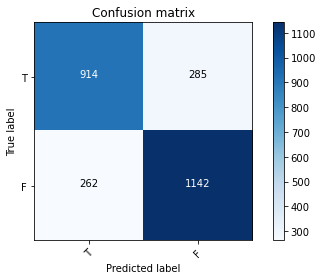

In [17]:
pipeline.fit(df_tfidfvect_FT, Y_train_balanced_FT)
predict_FT = pipeline.predict(df_tfidfvect_test_FT)

print("Classification Report:")
print(classification_report(Y_test_FT, predict_FT, target_names=['T','F']))

cnf = confusion_matrix(Y_test_FT, predict_FT)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = ['T','F'])

##### PJ: Prospective - Judging
Create sparse TFIDF-Document Termmatrix. \
Then fit the Model and determine the Accuracy.

In [18]:
df_tfidfvect_PJ, df_tfidfvect_test_PJ = sparseTFIDF(X_train_balanced_PJ, X_test, Y_train_balanced_PJ)

/var/folders/kh/405kw3wn56x2htwrgh2yhcfw0000gn/T/ipykernel_2215/3762352402.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features = features.append(pd.DataFrame(
/var/folders/kh/405kw3wn56x2htwrgh2yhcfw0000gn/T/ipykernel_2215/3762352402.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features = features.append(pd.DataFrame(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.

Classification Report:
              precision    recall  f1-score   support

           J       0.72      0.71      0.71      1071
           P       0.80      0.81      0.80      1532

    accuracy                           0.77      2603
   macro avg       0.76      0.76      0.76      2603
weighted avg       0.76      0.77      0.77      2603



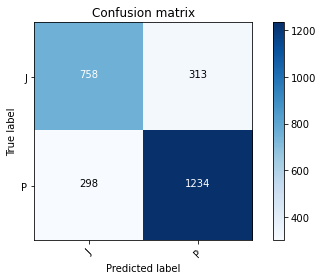

In [19]:
pipeline.fit(df_tfidfvect_PJ, Y_train_balanced_PJ)
predict_PJ = pipeline.predict(df_tfidfvect_test_PJ)

print("Classification Report:")
print(classification_report(Y_test_PJ, predict_PJ, target_names=['J','P']))

cnf = confusion_matrix(Y_test_PJ, predict_PJ)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = ['J','P'])

##### Combining the results from the four models.

In [20]:
predict = pd.merge(pd.DataFrame(predict_EI).reset_index(), pd.DataFrame(predict_NS).reset_index(), on = "index")
predict.columns =['index', 'EI', 'NS']
predict = pd.merge(predict, pd.DataFrame(predict_FT).reset_index(), on = "index")
predict = pd.merge(predict, pd.DataFrame(predict_PJ).reset_index(), on = "index")
predict = predict.drop('index', axis = 1)
predict.columns =['EI', 'NS', 'FT', 'PJ']
#display(predict.head())

test = pd.merge(pd.DataFrame(Y_test_EI).reset_index(), pd.DataFrame(Y_test_NS).reset_index(), on = "index")
test.columns =['index', 'EI', 'NS']
test = pd.merge(test, pd.DataFrame(Y_test_FT).reset_index(), on = "index")
test = pd.merge(test, pd.DataFrame(Y_test_PJ).reset_index(), on = "index")
test = test.drop('index', axis = 1)
test.columns =['EI', 'NS', 'FT', 'PJ']
#display(test.head())

In [21]:
predict['predict_numType'] = predict.apply(lambda row: numMBTItype(row), axis = 1)
predict['predict_Type'] = predict.apply(lambda row: MBTItype(row), axis = 1)

test['test_numType'] = test.apply(lambda row: numMBTItype(row), axis = 1)
test['test_Type'] = test.apply(lambda row: MBTItype(row), axis = 1)

Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.61      0.46      0.53       436
        INTP       0.46      0.57      0.51       196
        ENTJ       0.58      0.47      0.52       378
        INTJ       0.61      0.35      0.44       365
        INFP       0.18      0.27      0.22        74
        ISFP       0.15      0.31      0.20        55
        ISFJ       0.61      0.56      0.59       545
        ENFP       0.38      0.26      0.31       212
        INFJ       0.24      0.33      0.28        73
        ISTP       0.39      0.35      0.37        86
        ENTP       0.25      0.34      0.29        58
        ESTP       0.29      0.23      0.26        61
        ESTJ       0.08      0.29      0.12        28
        ISTJ       0.01      0.07      0.02        14
        ESFP       0.01      0.09      0.02        11
        ESFJ       0.03      0.18      0.04        11

    accuracy                           0.43      2603
   

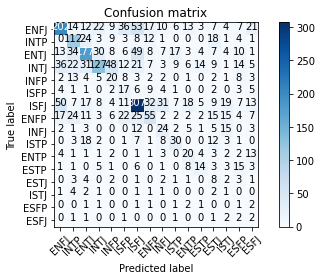

In [22]:
print("Classification Report:")
print(classification_report(test['test_numType'], predict["predict_numType"], target_names=test['test_Type'].unique()))

cnf = confusion_matrix(test['test_numType'], predict['predict_numType'])
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = test['test_Type'].unique())

#### KNN

In [23]:
pipeline.set_params(estimator=KNeighborsClassifier())

Pipeline(steps=[('estimator', KNeighborsClassifier())])

##### EI: Extroverted - Introverted
##### Grid Search
Determening best k for the Model.

In [24]:
parameters = {'n_neighbors':range(1,200,2)}

gs = GridSearchCV(KNeighborsClassifier(), parameters, scoring='accuracy', cv=cv, return_train_score=False)

gs.fit(df_tfidfvect_EI, Y_train_balanced_EI)
results = pd.DataFrame(gs.cv_results_)

print(f"best score is {gs.best_score_} with params {gs.best_params_}")

best score is 0.8567608044501497 with params {'n_neighbors': 1}


Fit Model and determine Accuracy

Classification Report k=1:
              precision    recall  f1-score   support

           I       0.83      0.83      0.83      2002
           E       0.44      0.44      0.44       601

    accuracy                           0.74      2603
   macro avg       0.63      0.64      0.64      2603
weighted avg       0.74      0.74      0.74      2603



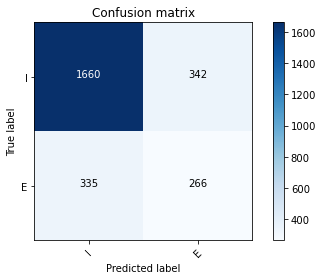

In [25]:
for k in gs.best_params_.values():
    pipeline.set_params(estimator__n_neighbors=k)
    pipeline.fit(df_tfidfvect_EI, Y_train_balanced_EI)
    predict_EI = pipeline.predict(df_tfidfvect_test_EI)
    
    print(f"Classification Report k={k}:")
    print(classification_report(Y_test_EI, predict_EI, target_names=['I','E']))
    
    cnf = confusion_matrix(Y_test_EI, predict_EI)
    np.set_printoptions(precision = 2)
    plot_confusion_matrix(cnf, classes = ['I','E'])

##### NS: Intuitive - Observant
##### Grid Search
Determening best k for the Model.

In [26]:
parameters = {'n_neighbors':range(1,200,2)}

gs = GridSearchCV(KNeighborsClassifier(), parameters, scoring='accuracy', cv=cv, return_train_score=False)

gs.fit(df_tfidfvect_NS, Y_train_balanced_NS)
results = pd.DataFrame(gs.cv_results_)

print(f"best score is {gs.best_score_} with params {gs.best_params_}")

best score is 0.9159478627563734 with params {'n_neighbors': 1}


Fit Model and determine Accuracy

Classification Report k=1:
              precision    recall  f1-score   support

           S       0.37      0.44      0.40       342
           N       0.91      0.89      0.90      2261

    accuracy                           0.83      2603
   macro avg       0.64      0.66      0.65      2603
weighted avg       0.84      0.83      0.83      2603



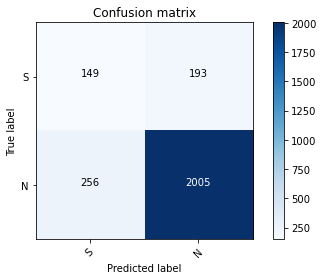

In [27]:
for k in gs.best_params_.values():
    pipeline.set_params(estimator__n_neighbors=k)
    pipeline.fit(df_tfidfvect_NS, Y_train_balanced_NS)
    predict_NS = pipeline.predict(df_tfidfvect_test_NS)
    
    print(f"Classification Report k={k}:")
    print(classification_report(Y_test_NS, predict_NS, target_names=['S','N']))
    
    cnf = confusion_matrix(Y_test_NS, predict_NS)
    np.set_printoptions(precision = 2)
    plot_confusion_matrix(cnf, classes = ['S','N'])

##### FT: Feeling - Thinking
##### Grid Search
Determening best k for the Model.

In [28]:
parameters = {'n_neighbors':range(1,200,2)}

gs = GridSearchCV(KNeighborsClassifier(), parameters, scoring='accuracy', cv=cv, return_train_score=False)

gs.fit(df_tfidfvect_FT, Y_train_balanced_FT)
results = pd.DataFrame(gs.cv_results_)

print(f"best score is {gs.best_score_} with params {gs.best_params_}")

best score is 0.783433393426198 with params {'n_neighbors': 167}


Fit Model and determine Accuracy

Classification Report k=167:
              precision    recall  f1-score   support

           T       0.75      0.74      0.75      1199
           F       0.78      0.79      0.79      1404

    accuracy                           0.77      2603
   macro avg       0.77      0.77      0.77      2603
weighted avg       0.77      0.77      0.77      2603



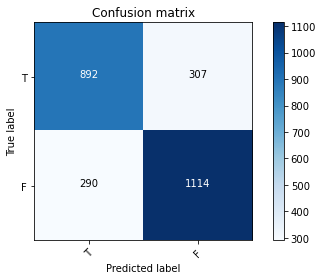

In [29]:
for k in gs.best_params_.values():
    pipeline.set_params(estimator__n_neighbors=k)
    pipeline.fit(df_tfidfvect_FT, Y_train_balanced_FT)
    predict_FT = pipeline.predict(df_tfidfvect_test_FT)
    
    print(f"Classification Report k={k}:")
    print(classification_report(Y_test_FT, predict_FT, target_names=['T','F']))
    
    cnf = confusion_matrix(Y_test_FT, predict_FT)
    np.set_printoptions(precision = 2)
    plot_confusion_matrix(cnf, classes = ['T','F'])

##### PJ: Prospective - Judging
##### Grid Search
Determening best k for the Model.

In [30]:
parameters = {'n_neighbors':range(1,200,2)}

gs = GridSearchCV(KNeighborsClassifier(), parameters, scoring='accuracy', cv=cv, return_train_score=False)

gs.fit(df_tfidfvect_PJ, Y_train_balanced_PJ)
results = pd.DataFrame(gs.cv_results_)

print(f"best score is {gs.best_score_} with params {gs.best_params_}")

best score is 0.7414390956308715 with params {'n_neighbors': 87}


Fit Model and determine Accuracy

Classification Report k=87:
              precision    recall  f1-score   support

           J       0.69      0.69      0.69      1071
           P       0.78      0.78      0.78      1532

    accuracy                           0.74      2603
   macro avg       0.74      0.74      0.74      2603
weighted avg       0.74      0.74      0.74      2603



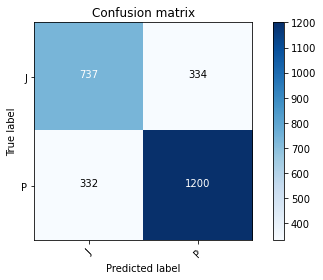

In [31]:
for k in gs.best_params_.values():
    pipeline.set_params(estimator__n_neighbors=k)
    pipeline.fit(df_tfidfvect_PJ, Y_train_balanced_PJ)
    predict_PJ = pipeline.predict(df_tfidfvect_test_PJ)
    
    print(f"Classification Report k={k}:")
    print(classification_report(Y_test_PJ, predict_PJ, target_names=['J','P']))
    
    cnf = confusion_matrix(Y_test_PJ, predict_PJ)
    np.set_printoptions(precision = 2)
    plot_confusion_matrix(cnf, classes = ['J','P'])

##### Combining the results from the four models.

In [32]:
predict = pd.merge(pd.DataFrame(predict_EI).reset_index(), pd.DataFrame(predict_NS).reset_index(), on = "index")
predict.columns =['index', 'EI', 'NS']
predict = pd.merge(predict, pd.DataFrame(predict_FT).reset_index(), on = "index")
predict = pd.merge(predict, pd.DataFrame(predict_PJ).reset_index(), on = "index")
predict = predict.drop('index', axis = 1)
predict.columns =['EI', 'NS', 'FT', 'PJ']
#display(predict.head())

test = pd.merge(pd.DataFrame(Y_test_EI).reset_index(), pd.DataFrame(Y_test_NS).reset_index(), on = "index")
test.columns =['index', 'EI', 'NS']
test = pd.merge(test, pd.DataFrame(Y_test_FT).reset_index(), on = "index")
test = pd.merge(test, pd.DataFrame(Y_test_PJ).reset_index(), on = "index")
test = test.drop('index', axis = 1)
test.columns =['EI', 'NS', 'FT', 'PJ']
#display(test.head())

In [33]:
predict['predict_numType'] = predict.apply(lambda row: numMBTItype(row), axis = 1)
predict['predict_Type'] = predict.apply(lambda row: MBTItype(row), axis = 1)

test['test_numType'] = test.apply(lambda row: numMBTItype(row), axis = 1)
test['test_Type'] = test.apply(lambda row: MBTItype(row), axis = 1)

Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.51      0.45      0.48       436
        INTP       0.43      0.37      0.40       196
        ENTJ       0.40      0.48      0.44       378
        INTJ       0.49      0.39      0.43       365
        INFP       0.24      0.30      0.27        74
        ISFP       0.12      0.22      0.15        55
        ISFJ       0.48      0.50      0.49       545
        ENFP       0.33      0.21      0.25       212
        INFJ       0.26      0.33      0.29        73
        ISTP       0.25      0.19      0.21        86
        ENTP       0.26      0.34      0.30        58
        ESTP       0.23      0.21      0.22        61
        ESTJ       0.13      0.11      0.12        28
        ISTJ       0.03      0.07      0.04        14
        ESFP       0.00      0.00      0.00        11
        ESFJ       0.00      0.00      0.00        11

    accuracy                           0.39      2603
   

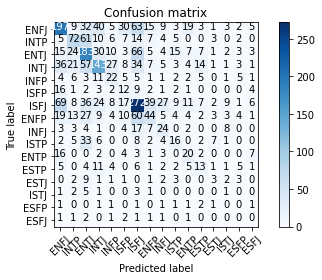

In [34]:
print("Classification Report:")
print(classification_report(test['test_numType'], predict["predict_numType"], target_names=test['test_Type'].unique()))

cnf = confusion_matrix(test['test_numType'], predict['predict_numType'])
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = test['test_Type'].unique())